<a href="https://colab.research.google.com/github/ahmadpnb/combinationforecast/blob/main/Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#please install all packages if not available, can use similar code as shown below for installation. Once installed, no need to reinstall
!pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.7/981.7 kB 13.0 MB/s eta 0:00:00


In [ ]:
#packages needed for this script

import datetime as dt #package to handle date
import statistics as st #package for statistical methods
from dateutil.relativedelta import relativedelta #package to do calculations with date
import pandas as pd #package for data handling
import numpy as np #package for default arithmetic
import seaborn as sns #package for plotting graph
import matplotlib.pyplot as plt #package for plotting graph
import statsmodels.api as sm #package for models and other statistical test
from statsmodels.tsa.stattools import adfuller #package for ADF test for stationarity
from arch.unitroot import PhillipsPerron #package for Phillips Perron test for stationarity
from statsmodels.tsa.stattools import kpss #package for KPSS test for stationarity
from statsmodels.tsa.stattools import acf, pacf #package for acf and pacf
from statsmodels.tsa.arima.model import ARIMA #package for ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #package to plot autocorrelation function and partial
from statsmodels.stats.diagnostic import acorr_ljungbox #package for ljungbox text for white noise
from sklearn.model_selection import train_test_split #for train_test
from statsmodels.stats.diagnostic import het_breuschpagan #package for Breusch Pagan test for heteroscedasticity
from statsmodels.stats.diagnostic import linear_lm #package for Lagrange multiplier test for linearity
from statsmodels.stats.outliers_influence import variance_inflation_factor #package for vif to test for multicollinearity
from statsmodels.stats.stattools import jarque_bera # package for jarque bera test of normality
from statsmodels.tools.tools import maybe_unwrap_results #package for regression diagnostics graphics
from statsmodels.graphics.gofplots import ProbPlot #package for regression diagnostics graphics
from typing import Type
from statsmodels.tsa.api import VAR #package for VAR model
from statsmodels.tsa.vector_ar.vecm import VECM #package for VECM model
from statsmodels.tsa.ar_model import ar_select_order #package to select lag order
from statsmodels.tsa.stattools import grangercausalitytests #package for granger causality tests
from statsmodels.tsa.vector_ar.vecm import select_coint_rank #package for Johansen cointegration test
from statsmodels.tsa.vector_ar.vecm import coint_johansen #package for Johansen cointegration test
from statsmodels.tsa.vector_ar.vecm import select_order #package for selecting optimal lag length
from dateutil.relativedelta import relativedelta #package for date handling

In [ ]:
# Functions for EDA

def eda(df):
  print(df.info())
  print()
  print()
  display(df.head(10), df.tail(10))
  print()
  print()
  print('Data summary statistics')
  display(df.describe())
  print()
  print()
  df.select_dtypes(include = np.number).plot(subplots = True, sharex = True, figsize = (11.69,8.27), use_index = True, title = "Graphs of all variables", legend = True, xlabel = "Date")
  plt.show()
  print()
  print()
  pairplot = sns.pairplot(data = df.select_dtypes(include = np.number), kind = "reg", diag_kind = "hist", dropna = True)
  pairplot.fig.subplots_adjust(top = .95)
  pairplot.fig.suptitle("Variables distribution and two way relationships")
  plt.show()
  print()
  print()
  sns.heatmap(data = df.corr(numeric_only = True), cmap = "RdYlGn", center = 0, robust = True, square = True, annot = True, fmt = ".0%", linewidth = 0.5)
  plt.title("Correlation matrix between variables")
  plt.show()

In [ ]:
# functions for transformation

# function to log selected columns
def transform_log(df):

  print(df.columns)
  input_string = input("Enter all columns' name to be log separated by space: ")
  columns = input_string.split(" ")

  for i in columns:
    df[i] = df[i].transform(np.log)

  return df


# function to difference selected columns
def transform_diff(df, second_diff = False):

  print(df.columns)
  input_string = input("Enter all columns' name to be diff separated by space: ")
  columns = input_string.split(" ")

  second_diff = int(input("1 if need second difference, 0 if do not need second difference: "))

  for i in columns:
    print("Column: " + i)
    df[i] = df[i].diff(int(input("Please enter the number of first difference i.e. 1 for difference to previous row, 12 for difference to previous 12 rows: ")))

  if second_diff == True:
      print(df.columns)
      input_string_2 = input("Enter all columns' name to be second differenced separated by space: ")
      columns_2 = input_string_2.split(" ")

      for i in columns_2:
        print("Column: " + i)
        df[i] = df[i].diff(int(input("Please enter the number of second difference i.e. 1 for difference to previous row, 12 for difference to previous 12 rows: ")))

  return df


# function to perform data transformation
def transform_data(df, to_log = False, to_diff = False):

  transform = df.copy()
  to_log = int(input("1 if need to log, 0 if no need to log: "))
  to_diff = int(input("1 if need to diff, 0 if no need to diff: "))

  if to_log == True and to_diff == False:
    transform_log(transform)

  elif to_log == False and to_diff == True:
    transform_diff(transform)

  elif to_log == True and to_diff == True:
    transform_log(transform)
    transform_diff(transform)

  return transform


# function to invert differenced columns
def invert_diff(original_df, differenced_df, second_diff = False):

    second_diff = int(input("1 if need to undo second differencing, 0 if only inversing first difference: "))

    print("Please log the variables that was log before differenced")
    original_df = transform_log(original_df)

    if second_diff == True:

      print(original_df.columns)
      input_string = input("Enter all columns' name to undo second differencing separated by space: ")
      columns = input_string.split(" ")

      for i in columns:

        print("Column: " + i)
        first_d = int(input("Please insert the number of difference for the first difference: "))
        second_d = int(input("Please insert the number of difference for the second difference: "))
        diff = original_df[i].diff(first_d)
        first_invert = diff.shift(second_d) + differenced_df[i]
        second_invert = original_df[i].shift(first_d) + first_invert
        differenced_df[i] = second_invert

      print(original_df.columns)
      input_string2 = input("Enter all columns' name to undo first differencing other than previously listed separated by space: ")
      columns_2 = input_string2.split(" ")

      for i in columns_2:

        print("Column: " + i)
        first_d = int(input("Please insert the number of difference for the first difference: "))
        first_invert = original_df[i].shift(first_d) + differenced_df[i]
        differenced_df[i] = first_invert

    elif second_diff == False:

      print(original_df.columns)
      input_string = input("Enter all columns' name to undo first differencing separated by space: ")
      columns = input_string.split(" ")

      for i in columns:

        print("Column: " + i)
        first_d = int(input("Please insert the number of difference for the first difference: "))
        first_invert = original_df[i].shift(first_d) + differenced_df[i]
        differenced_df[i] = first_invert

    return differenced_df


# Function to invert differenced forecast
def invert_diff_forecast(original_df, differenced_df):

  second_diff = int(input("1 if need to undo second differencing, 0 if only inversing first difference: "))

  log = int(input("1 if there are variables that are log before differenced, 0 if none: "))

  if log == True:
    print("Please log the variables that was log before differenced")
    original_df = transform_log(original_df)

  if second_diff == True:

    print(differenced_df.columns)
    input_string = input("Enter all columns' name to undo second differencing separated by space: ")
    columns = input_string.split(" ")

    for i in columns:

      print("Column: " + i)
      first_d = int(input("Please insert the number of difference for the first difference: "))
      second_d = int(input("Please insert the number of difference for the second difference: "))
      diff1 = original_df[i].diff(first_d)
      diff2 = diff1.diff(second_d)
      first_invert = diff2[-1] + differenced_df[i].cumsum()
      second_invert1 = original_df[i].shift(first_d)[-first_d:].set_axis(first_invert[:first_d].index.values) + first_invert[:first_d]
      second_invert2 = second_invert1.set_axis(first_invert[(len(differenced_df) - first_d):].index.values) + first_invert[len(differenced_df) - first_d:]
      differenced_df[i] = pd.concat([second_invert1,second_invert2])

    fd = int(input("1 if there are other columns that need to invert first differencing, 0 if none: "))

    if fd == True:

      print(differenced_df.columns)
      input_string2 = input("Enter all columns' name to undo first differencing other than previously listed separated by space: ")
      columns_2 = input_string2.split(" ")

      for i in columns_2:

        print("Column: " + i)
        first_d = int(input("Please insert the number of difference for the first difference: "))
        first_invert = original_df[i].iloc[-first_d] + differenced_df[i].cumsum()
        differenced_df[i] = first_invert

  elif second_diff == False:

    print(differenced_df.columns)
    input_string = input("Enter all columns' name to undo first differencing separated by space: ")
    columns = input_string.split(" ")

    for i in columns:

      print("Column: " + i)
      first_d = int(input("Please insert the number of difference for the first difference: "))
      first_invert = original_df[i].iloc[-first_d] + differenced_df[i].cumsum()
      differenced_df[i] = first_invert


  return differenced_df


# Function to invert log transformation
def invert_log(df):

  print(df.columns)
  input_string = input("Enter all columns' name to be inverted its log separated by space: ")
  columns = input_string.split(" ")

  for i in columns:
    df[i] = df[i].apply(np.exp)

  return df


# Function to perform inverse transformation
def inverse_transformation(original_data, differenced_data, log = False, diff = False):

  original_data = original_data.copy()
  differenced_data = differenced_data.copy()

  log = int(input("1 if need to invert log, 0 if no need to invert log: "))
  diff = int(input("1 if need to invert diff, 0 if no need to invert diff: "))

  if diff == True and log == True:
    invert_data = invert_diff(original_data, differenced_data)
    invert_data = invert_log(invert_data)

  elif diff == True and log == False:
    invert_data = invert_diff(original_data, differenced_data)

  elif diff == False and log == True:
    invert_data = invert_log(differenced_data)

  else:
    invert_data = differenced_data

  return invert_data

# Function to perform inverse transformation for forecast
def inverse_transformation_forecast(original_data, differenced_data):

  original_data = original_data.copy()
  differenced_data = differenced_data.copy()

  log = int(input("1 if need to invert log, 0 if no need to invert log: "))
  diff = int(input("1 if need to invert diff, 0 if no need to invert diff: "))

  if diff == True and log == True:
    invert_data = invert_diff_forecast(original_data, differenced_data)
    invert_data = invert_log(invert_data)

  elif diff == True and log == False:
    invert_data = invert_diff_forecast(original_data, differenced_data)

  elif diff == False and log == True:
    invert_data = invert_log(differenced_data)

  else:
    invert_data = differenced_data

  return invert_data

In [ ]:
# Functions for testing

# function for colour formatting for pvalue - hypothesis testing
def pvalue_formatting(col):
    if col.name == '10%':
        return ['background-color: green' if c < 0.1 else 'background-color: red' for c in col.values]
    if col.name == '5%':
        return ['background-color: green' if c < 0.05 else 'background-color: red' for c in col.values]
    if col.name == '1%':
        return ['background-color: green' if c < 0.01 else 'background-color: red' for c in col.values]

def pvalue_formatting2(col):
    if col.name == '10%':
        return ['background-color: red' if c < 0.1 else 'background-color: green' for c in col.values]
    if col.name == '5%':
        return ['background-color: red' if c < 0.05 else 'background-color: green' for c in col.values]
    if col.name == '1%':
        return ['background-color: red' if c < 0.01 else 'background-color: green' for c in col.values]


# function to perform ADF test
def adf_test(df):

  indicator = []
  pvalue = []

  for column in df:
    adf = adfuller(df[column], regression = 'ct')
    p_value = adf[1]
    indicator.append(column)
    pvalue.append(p_value)

  adf_test = pd.DataFrame({'Indicator':indicator,'10%':pvalue,'5%':pvalue,'1%':pvalue}).style.apply(pvalue_formatting, subset = ['10%','5%','1%'])

  print("ADF test for stationarity: H0 is time series is not stationary")
  display(adf_test)


# Function to perform Phillips Perron test
def pp_test(df):

  indicator = []
  pvalue = []

  for column in df:
    pp = PhillipsPerron(df[column])
    p_value = pp.pvalue
    indicator.append(column)
    pvalue.append(p_value)

  pp_test = pd.DataFrame({'Indicator':indicator,'10%':pvalue,'5%':pvalue,'1%':pvalue}).style.apply(pvalue_formatting, subset = ['10%','5%','1%'])

  print("PP test for stationarity: H0 is time series is not stationary")
  display(pp_test)


# Function to perform KPSS test
def kpss_test(df):

  indicator = []
  pvalue = []

  for column in df:
    kpss_test = kpss(df[column], regression = 'ct')
    p_value = kpss_test[1]
    indicator.append(column)
    pvalue.append(p_value)

  kpss_test = pd.DataFrame({'Indicator':indicator,'10%':pvalue,'5%':pvalue,'1%':pvalue}).style.apply(pvalue_formatting2, subset = ['10%','5%','1%'])

  print("KPSS test for stationarity: H0 is time series is stationary")
  display(kpss_test)


# Function to perform all stationarity test
def stationarity_test(df):

  print("Stationarity test using ADF, PP, and KPSS. Green cells indicate series is stationary while red otherwise")
  print()
  adf_test(df)
  print()
  pp_test(df)
  print()
  kpss_test(df)


# Function to estimate ACF and PACF for autocorrelation
def acf_pacf_analysis(x, max_lags=24):
    acf_values = sm.tsa.acf(x)
    pacf_values = sm.tsa.pacf(x)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    sm.graphics.tsa.plot_acf(x, lags=max_lags, ax=plt.gca())
    plt.xlabel('Lags')
    plt.ylabel('ACF')

    plt.subplot(1, 2, 2)
    sm.graphics.tsa.plot_pacf(x, lags=max_lags, ax=plt.gca())
    plt.xlabel('Lags')
    plt.ylabel('PACF')

    plt.tight_layout()
    plt.suptitle("ACF and PACF graph for " + x.name)
    plt.show()


# Function to graph ACF and PACF
def acf_pacf_graph(df):
  for column in df:
    acf_pacf_analysis(df[column])

# Function for accuracy testing
def forecast_accuracy(forecast, actual):
  forecast = forecast.squeeze()
  actual = actual.squeeze()
  mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
  me = np.mean(forecast - actual)             # ME
  mae = np.mean(np.abs(forecast - actual))    # MAE
  mpe = np.mean((forecast - actual)/actual)   # MPE
  rmse = np.mean((forecast - actual)**2)**.5  # RMSE
  corr = np.corrcoef(forecast, actual)[0,1]   # corr
  mins = np.amin(np.hstack([np.array(forecast)[:,None], np.array(actual)[:,None]]), axis=1)
  maxs = np.amax(np.hstack([np.array(forecast)[:,None], np.array(actual)[:,None]]), axis=1)
  minmax = 1 - np.mean(mins/maxs)             # minmax
  accuracy_prod = ({'mape':mape, 'me':me, 'mae': mae,'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})
  print('Forecast Accuracy of:',input("Please put model name: ")," used to forecast ", input("Please put dependent variable name: "))
  for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

# Function for random walk accuracy testing
def rw_forecast_accuracy(forecast, actual):
  forecast = forecast.squeeze()
  actual = actual.squeeze()
  mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
  me = np.mean(forecast - actual)             # ME
  mae = np.mean(np.abs(forecast - actual))    # MAE
  mpe = np.mean((forecast - actual)/actual)   # MPE
  rmse = np.mean((forecast - actual)**2)**.5  # RMSE
  corr = np.corrcoef(forecast, actual)[0,1]   # corr
  mins = np.amin(np.hstack([np.array(forecast)[:,None], np.array(actual)[:,None]]), axis=1)
  maxs = np.amax(np.hstack([np.array(forecast)[:,None], np.array(actual)[:,None]]), axis=1)
  minmax = 1 - np.mean(mins/maxs)             # minmax
  accuracy_prod = ({'mape':mape, 'me':me, 'mae': mae,'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})
  print('Forecast Accuracy of:',"Random walk model"," used to forecast ", input("Please put dependent variable name: "))
  for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

def adjust(val, length= 6): return str(val).ljust(length)


# Function to find the optimal lag for VECM model

def vecm_optimal_lag(df):

  if df.index.freq == 'm':
    lags = 12
    seasons = 12
  elif df.index.freq == 'q':
    lags = 4
    seasons = 4

  deterministic = input("n - no deterministic terms, co - constant outside the cointegration relation, ci - constant within the cointegration relation, lo - linear trend outside the cointegration relation, li - linear trend within the cointegration relation - Combinations of these are possible (e.g. cili or colo for linear trend with intercept): ")

  result = select_order(df, deterministic = deterministic, maxlags = lags, seasons = seasons)
  print()
  print()
  print(result.summary())
  print()
  print()
  lag = [result.aic, result.bic, result.fpe, result.hqic]
  if len(st.multimode(lag)) != 1:
    optimal_lag = result.aic
  elif len(st.multimode(lag)) == 1:
    optimal_lag = st.mode(lag)
  print("The optimal lag for the model is",optimal_lag)

  return optimal_lag


# Functio to test cointegraion rank

def cointegration_test(df):

  lag = int(input("Insert optimal lag number obtained from test: "))
  deterministic = int(input("-1 - no deterministic terms, 0 - constant term, 1 - linear trend "))
  print()
  print()
  trace_coint_rank_result = select_coint_rank(df, det_order = deterministic, k_ar_diff = lag, method = "trace")
  print(trace_coint_rank_result.summary())
  print("Trace method cointegration test suggest a cointegration rank of",trace_coint_rank_result.rank)
  print()
  print()
  maxeig_coint_rank_result = select_coint_rank(df, det_order = deterministic, k_ar_diff = lag, method = "maxeig")
  print(maxeig_coint_rank_result.summary())
  print("Maximum Eigenvalue method cointegration test suggest a cointegration rank of",maxeig_coint_rank_result.rank)
  rank = [trace_coint_rank_result.rank, maxeig_coint_rank_result.rank]
  if trace_coint_rank_result.rank != maxeig_coint_rank_result.rank:
    coint_rank = trace_coint_rank_result.rank
  else:
    coint_rank = st.mode(rank)

  return coint_rank

In [ ]:
# Function to forecast ARIMA

# Function to forecast using ARIMA model

def arima_forecast(df):

  print("Variables selection for the model")
  variables_input = input("Enter columns to be used in model seperated by space: ").lower()
  variables_list  = variables_input.split(" ")

  print()
  print()
  print("Sample selection and sample transformation")
  og_df = df[variables_list].copy(deep = True).loc[input('Please insert model sample start date in YYYY-MM-DD format: '):input('Please insert model sample end date in YYYY-MM-DD format: ')].dropna()
  transformed_df = transform_data(og_df).dropna()

  print()
  print()
  print("Model parameter setting and fitting")
  model = ARIMA(transformed_df, order = (int(input("Please put the desired AR process number: ")), int(input("Please put the desired number of difference: ")), int(input("Please put the desired MA process number: "))), seasonal_order = (int(input("Please put the desired seasonal AR process number: ")), int(input("Please put the desired number of seasonal differnce: ")), int(input("Please put the desired seasonal MA process number: ")), int(input("Please put the frequency of the data: "))))
  fit = model.fit()

  print()
  print()
  print(fit.summary())

  print()
  print()
  print("Forecasting using the ARIMA model")
  forecast_horizon = int(input("Please enter your forecast horizon. For example, if your forecast horizon is 12 periods ahead from the last data point put '12'. "))
  forecast = fit.forecast(steps = forecast_horizon).to_frame(name = variables_list[0])
  forecast = inverse_transformation_forecast(og_df, forecast)

  print()
  print()
  print()
  freq = og_df.index.freq
  if freq == 'm':
    tail = 12*3
  elif freq == 'q':
    tail = 4*3
  plt.plot(og_df.tail(tail), color = "mediumblue", label = 'Historical')
  plt.plot(forecast, color = "darkorange", label = 'Forecast')
  plt.ylabel(input("Enter the Y label name and unit "))
  plt.xlabel('Date')
  plt.xticks(rotation=90)
  plt.title("ARIMA model forecast")
  plt.legend()
  plt.show()

  print()
  print()
  print()
  model_name = input("Enter the model name: ")
  print("Aggregating forecast into quarterly numbers")
  agg = int(input("1 for period avg, 0 for period end: "))
  forecast_range = pd.date_range(start = dt.date(transformed_df.index[-1].year, (transformed_df.index[-1].quarter + 1) * 3 + 1, 1) + dt.timedelta(days=-1), periods = 8, freq = "q")
  forecast['quarter'] = forecast.index.quarter
  forecast['year'] = forecast.index.year
  if agg == True:
    forecast = forecast.groupby(['year','quarter']).mean().reset_index().set_index(forecast_range).drop(['year', 'quarter'], axis=1)
    forecast.rename(columns = {variables_list[0]:model_name}, inplace = True)
    print('Forecast aggregated into quarterly average value')
    display(forecast)
  elif agg == False:
    forecast = forecast[forecast.index.isin(forecast_range)]
    forecast.rename(columns = {variables_list[0]:model_name}, inplace = True)
    print('Forecast aggregated into quarterly end value')
    display(forecast)

  return forecast

In [ ]:
# Function to forecast using OLS

def ols_forecast(df):

  print("Variables selection for the model")
  variables_input = input("Enter columns to be used in model seperated by space: ").lower()
  variables_list  = variables_input.split(" ")
  dependent_input = input("Please put your dependent variable name: ").lower()

  print()
  print("Sample selection and sample transformation")
  og_df = df[variables_list].copy(deep = True).loc[input('Please insert model sample start date in YYYY-MM-DD format: '):input('Please insert model sample end date in YYYY-MM-DD format: ')].dropna()
  transformed_df = transform_data(og_df).dropna()

  print()
  print("Model parameter setting and fitting")
  formula = input("Please put the formula of the ols, for example log brent linear model with balance and recession indicator as exogenous variables will have a formula such as 'np.log(brent) ~ balance + recession': ")
  model = sm.OLS.from_formula(formula = formula, data = transformed_df)
  fit = model.fit(cov_type = 'HAC', cov_kwds = {'maxlags':12, 'use_correction':True})

  print()
  print()
  print(fit.summary())

  print()
  print()
  print("Forecasting using the OLS model")
  new_df = data_q[variables_list].copy(deep = True).loc[data_q.index > og_df.index[-1]].dropna()
  new_transformed_df = transform_data(new_df).dropna()
  forecast = fit.predict(exog = new_transformed_df).to_frame(name = dependent_input)
  forecast = inverse_transformation_forecast(og_df, forecast)

  print()
  print()
  print()
  freq = og_df.index.freq
  if freq == 'm':
    tail = 12*3
  elif freq == 'q':
    tail = 4*3
  plt.plot(og_df[dependent_input].tail(tail), color = "mediumblue", label = 'Historical')
  plt.plot(forecast, color = "darkorange", label = 'Forecast')
  plt.ylabel(input("Enter the Y label name and unit "))
  plt.xlabel('Date')
  plt.xticks(rotation=90)
  plt.title("OLS model forecast")
  plt.legend()
  plt.show()

  print()
  print()
  print()
  model_name = input("Enter the model name: ")
  print("Aggregating forecast into quarterly numbers")
  agg = int(input("1 for period avg, 0 for period end: "))
  forecast_range = pd.date_range(start = dt.date(transformed_df.index[-1].year, (transformed_df.index[-1].quarter + 1) * 3 + 1, 1) + dt.timedelta(days=-1), periods = 8, freq = "q")
  forecast['quarter'] = forecast.index.quarter
  forecast['year'] = forecast.index.year
  if agg == True:
    forecast = forecast.groupby(['year','quarter']).mean().reset_index().set_index(forecast_range).drop(['year', 'quarter'], axis=1)
    forecast.rename(columns = {dependent_input:model_name}, inplace = True)
    print('Forecast aggregated into quarterly average value')
    display(forecast)
  elif agg == False:
    forecast = forecast[forecast.index.isin(forecast_range)]
    forecast.rename(columns = {dependent_input:model_name}, inplace = True)
    print('Forecast aggregated into quarterly end value')
    display(forecast)

  return forecast


In [ ]:
# Function to forecast using VAR

def var_forecast(df):

  print("Variables selection for the model")
  variables_input = input("Enter columns to be used in model seperated by space: ").lower()
  variables_list  = variables_input.split(" ")
  main_endog = input("Please enter the name of your main endogenous variables: ")
  var_list = variables_list.copy()
  var_list.remove(main_endog)

  print()
  print("Sample selection and sample transformation")
  og_df = df[variables_list].copy(deep = True).loc[input('Please insert model sample start date in YYYY-MM-DD format: '):input('Please insert model sample end date in YYYY-MM-DD format: ')].dropna()
  transformed_df = transform_data(og_df).dropna()

  print()
  print("Model parameter setting and fitting")

  if transformed_df.index.freq == 'm':
    lags = 12
  elif transformed_df.index.freq == 'q':
    lags = 4

  model = VAR(transformed_df)
  fit = model.fit(maxlags = lags, ic = 'aic', verbose = True, trend = 'c')

  print()
  print()
  print(fit.summary())

  print()
  print()
  print("Forecasting using the VAR model")
  freq = og_df.index.freq
  if freq == 'm':
    delta = relativedelta(months = 1)
  elif freq == 'q':
    delta = relativedelta(months = 3)
  forecast_horizon = int(input("Please enter your forecast horizon. For example, if your forecast horizon is 12 periods ahead from the last data point put '12'. "))
  forecast = pd.DataFrame(fit.forecast(steps = forecast_horizon, y = model.endog), columns = model.endog_names, index = pd.date_range(start = transformed_df.index[-1] + delta, periods = forecast_horizon, freq = transformed_df.index.freq))
  forecast = inverse_transformation_forecast(og_df, forecast)

  print()
  print()
  print()
  freq = og_df.index.freq
  if freq == 'm':
    tail = 12*3
  elif freq == 'q':
    tail = 4*3
  plt.plot(og_df[main_endog].tail(tail), color = "mediumblue", label = 'Historical')
  plt.plot(forecast[main_endog], color = "darkorange", label = 'Forecast')
  plt.ylabel(input("Enter the Y label name and unit "))
  plt.xlabel('Date')
  plt.xticks(rotation=90)
  plt.title("VAR model forecast")
  plt.legend()
  plt.show()


  print()
  print()
  print()
  model_name = input("Enter the model name: ")
  print("Aggregating forecast into quarterly numbers")
  agg = int(input("1 for period avg, 0 for period end: "))
  forecast_range = pd.date_range(start = dt.date(transformed_df.index[-1].year, (transformed_df.index[-1].quarter + 1) * 3 + 1, 1) + dt.timedelta(days=-1), periods = 8, freq = "q")
  forecast['quarter'] = forecast.index.quarter
  forecast['year'] = forecast.index.year
  if agg == True:
    forecast = forecast.groupby(['year','quarter']).mean().reset_index().set_index(forecast_range).drop(['year', 'quarter'], axis=1)[main_endog].to_frame(name = model_name)
    print('Forecast aggregated into quarterly average value')
    display(forecast)
  elif agg == False:
    forecast = forecast[forecast.index.isin(forecast_range)][main_endog].to_frame(name = model_name)
    print('Forecast aggregated into quarterly end value')
    display(forecast)

  return forecast

In [ ]:
# Function to forecast using VECM

def vecm_forecast(df):

  print("Variables selection for the model")
  variables_input = input("Enter columns to be used in model seperated by space: ").lower()
  variables_list  = variables_input.split(" ")
  main_endog = input("Please enter the name of your main endogenous variables: ")
  var_list = variables_list.copy()
  var_list.remove(main_endog)

  print()
  print("Sample selection and sample transformation")
  og_df = df[variables_list].copy(deep = True).loc[input('Please insert model sample start date in YYYY-MM-DD format: '):input('Please insert model sample end date in YYYY-MM-DD format: ')].dropna()
  transformed_df = transform_data(og_df).dropna()

  print()
  print("Model parameter setting and fitting")

  if transformed_df.index.freq == 'm':
    seasons = 12
    lags = 12
  elif transformed_df.index.freq == 'q':
    seasons = 4
    lags = 4

  deterministic = input("Select your deterministic terms: n - no deterministic terms, co - constant outside the cointegration relation, ci - constant within the cointegration relation, lo - linear trend outside the cointegration relation, li - linear trend within the cointegration relation - Combinations of these are possible (e.g. cili or colo for linear trend with intercept) ")
  optimal_lag = vecm_optimal_lag(transformed_df)
  coint_rank = cointegration_test(transformed_df)
  print()
  print()

  model = VECM(transformed_df, seasons = seasons, deterministic = deterministic, k_ar_diff = optimal_lag, dates = transformed_df.index, coint_rank = coint_rank)
  fit = model.fit()
  dateindex = og_df.shift(len(og_df) - len(fit.resid)).dropna().index

  print()
  print()
  print("Forecasting using the VECM model")
  freq = og_df.index.freq
  if freq == 'm':
    delta = relativedelta(months = 1)
  elif freq == 'q':
    delta = relativedelta(months = 3)
  forecast_horizon = int(input("Please enter your forecast horizon. For example, if your forecast horizon is 12 periods ahead from the last data point put '12'. "))
  forecast = pd.DataFrame(fit.predict(steps = forecast_horizon), columns = model.endog_names, index = pd.date_range(start = transformed_df.index[-1] + delta, periods = forecast_horizon, freq = transformed_df.index.freq))
  forecast = inverse_transformation_forecast(og_df, forecast)

  print()
  print()
  print()
  freq = og_df.index.freq
  if freq == 'm':
    tail = 12*3
  elif freq == 'q':
    tail = 4*3
  plt.plot(og_df[main_endog].tail(tail), color = "mediumblue", label = 'Historical')
  plt.plot(forecast[main_endog], color = "darkorange", label = 'Forecast')
  plt.ylabel(input("Enter the Y label name and unit "))
  plt.xlabel('Date')
  plt.xticks(rotation=90)
  plt.title("VECM model forecast")
  plt.legend()
  plt.show()


  print()
  print()
  print()
  model_name = input("Enter the model name: ")
  print("Aggregating forecast into quarterly numbers")
  agg = int(input("1 for period avg, 0 for period end: "))
  forecast_range = pd.date_range(start = dt.date(transformed_df.index[-1].year, (transformed_df.index[-1].quarter + 1) * 3 + 1, 1) + dt.timedelta(days=-1), periods = 8, freq = "q")
  forecast['quarter'] = forecast.index.quarter
  forecast['year'] = forecast.index.year
  if agg == True:
    forecast = forecast.groupby(['year','quarter']).mean().reset_index().set_index(forecast_range).drop(['year', 'quarter'], axis=1)[main_endog].to_frame(name = model_name)
    print('Forecast aggregated into quarterly average value')
    display(forecast)
  elif agg == False:
    forecast = forecast[forecast.index.isin(forecast_range)][main_endog].to_frame(name = model_name)
    print('Forecast aggregated into quarterly end value')
    display(forecast)

  return forecast

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#code to read original monthly data

path = '/content/drive/MyDrive/Internship/USDFAST.xlsx'
data_m = pd.read_excel(path, sheet_name = 'forecastm', index_col = 'Date').asfreq('m')

In [ ]:
data_m = pd.read_excel("/content/USDFAST.xlsx", sheet_name = 'forecastm', index_col = 'Date')

In [ ]:
data_m['ir10y_us'].info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 480 entries, 1985-01-31 to 2024-12-31
Freq: M
Series name: ir10y_us
Non-Null Count  Dtype  
--------------  -----  
462 non-null    float64
dtypes: float64(1)
memory usage: 7.5 KB


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 480 entries, 1985-01-31 to 2024-12-31
Freq: M
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Period    480 non-null    object 
 1   m2_us     459 non-null    float64
 2   ipi_us    461 non-null    float64
 3   ir_us     462 non-null    float64
 4   cpi_us    461 non-null    float64
 5   ca_us     301 non-null    float64
 6   ir10y_us  462 non-null    float64
 7   ir3y_us   451 non-null    float64
 8   ir2y_us   462 non-null    float64
 9   ir1y_us   381 non-null    float64
dtypes: float64(9), object(1)
memory usage: 41.2+ KB
None




,Period,m2_us,ipi_us,ir_us,cpi_us,ca_us,ir10y_us,ir3y_us,ir2y_us,ir1y_us
Date,,,,,,,,,,
1985-01-31,1Q1985,NaN,59.455503,8.25,48.382178,NaN,11.355650,10.326085,9.890550,8.983450
1985-02-28,1Q1985,27.290406,60.310981,9.00,48.611477,NaN,11.405077,10.434923,10.053077,9.154333
1985-03-31,1Q1985,27.430678,60.386510,8.50,48.794917,NaN,11.822000,10.972839,10.675000,9.813556
1985-04-30,2Q1985,27.537331,59.316562,8.25,49.024216,NaN,11.402381,10.397929,10.054619,9.118524
1985-05-31,2Q1985,27.700788,59.277924,7.75,49.207656,NaN,10.821636,9.697791,9.365318,8.422318
1985-06-30,2Q1985,27.968580,60.600652,7.75,49.345236,NaN,10.142053,8.992042,8.663947,7.774632
1985-07-31,3Q1985,28.164497,58.047643,7.75,49.436955,NaN,10.283182,9.093023,8.747682,7.822455
1985-08-31,3Q1985,28.332591,59.710575,8.00,49.528675,NaN,10.319409,9.272277,8.920318,8.024273
1985-09-30,3Q1985,28.476341,60.572056,8.00,49.666255,NaN,10.336400,9.302610,8.952650,8.028950


,Period,m2_us,ipi_us,ir_us,cpi_us,ca_us,ir10y_us,ir3y_us,ir2y_us,ir1y_us
Date,,,,,,,,,,
2024-03-31,1Q2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-04-30,2Q2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-31,2Q2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-30,2Q2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-07-31,3Q2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-08-31,3Q2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-09-30,3Q2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-10-31,4Q2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-11-30,4Q2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN




Data summary statistics


,m2_us,ipi_us,ir_us,cpi_us,ca_us,ir10y_us,ir3y_us,ir2y_us,ir1y_us
count,459.000000,461.000000,462.000000,461.000000,301.000000,462.000000,451.000000,462.000000,381.000000
mean,90.735899,93.265883,3.411667,87.473926,-3.062558,4.829704,4.018576,3.784575,3.594212
std,60.220324,17.681544,2.719126,23.289842,1.345253,2.455149,2.727231,2.747084,2.885312
min,27.290406,58.047643,0.250000,48.382178,-5.940000,0.616700,0.157114,0.114290,0.039371
25%,40.415096,76.249525,0.500000,68.331228,-4.130000,2.707273,1.437186,1.003404,0.409664
50%,71.296345,100.007977,3.000000,85.941423,-2.693333,4.535534,4.115240,3.899264,3.584043
75%,126.353618,108.118864,5.500000,107.126855,-2.060000,6.603683,6.144509,5.914023,5.841591
max,251.605929,115.784659,9.750000,139.472290,-0.890000,11.822000,10.972839,10.675000,9.813556


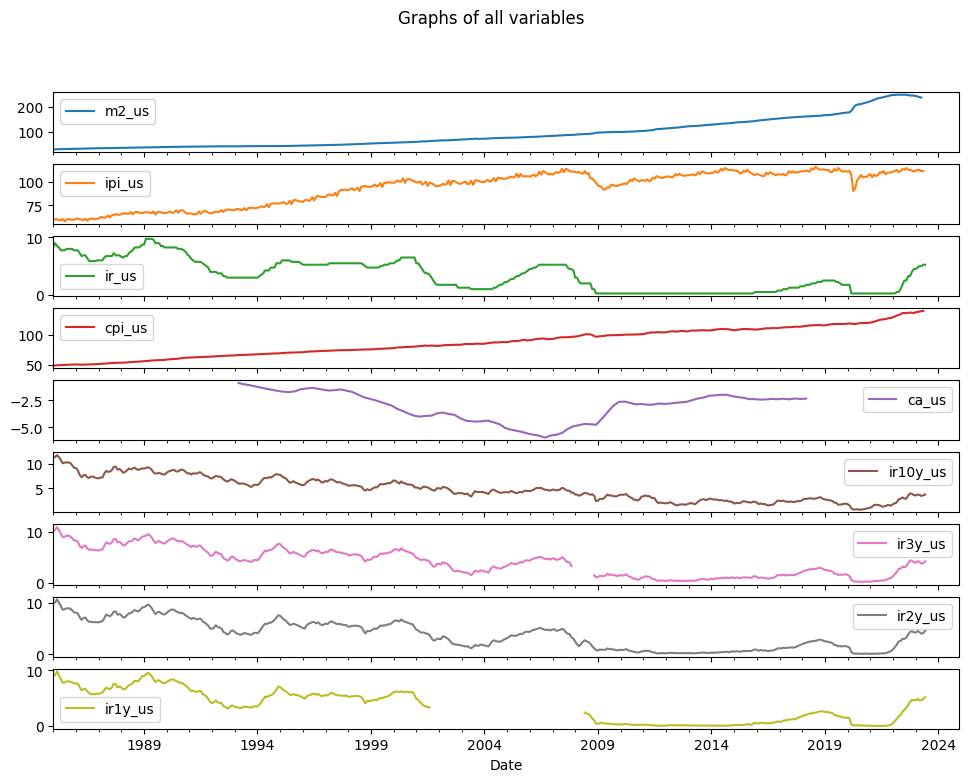

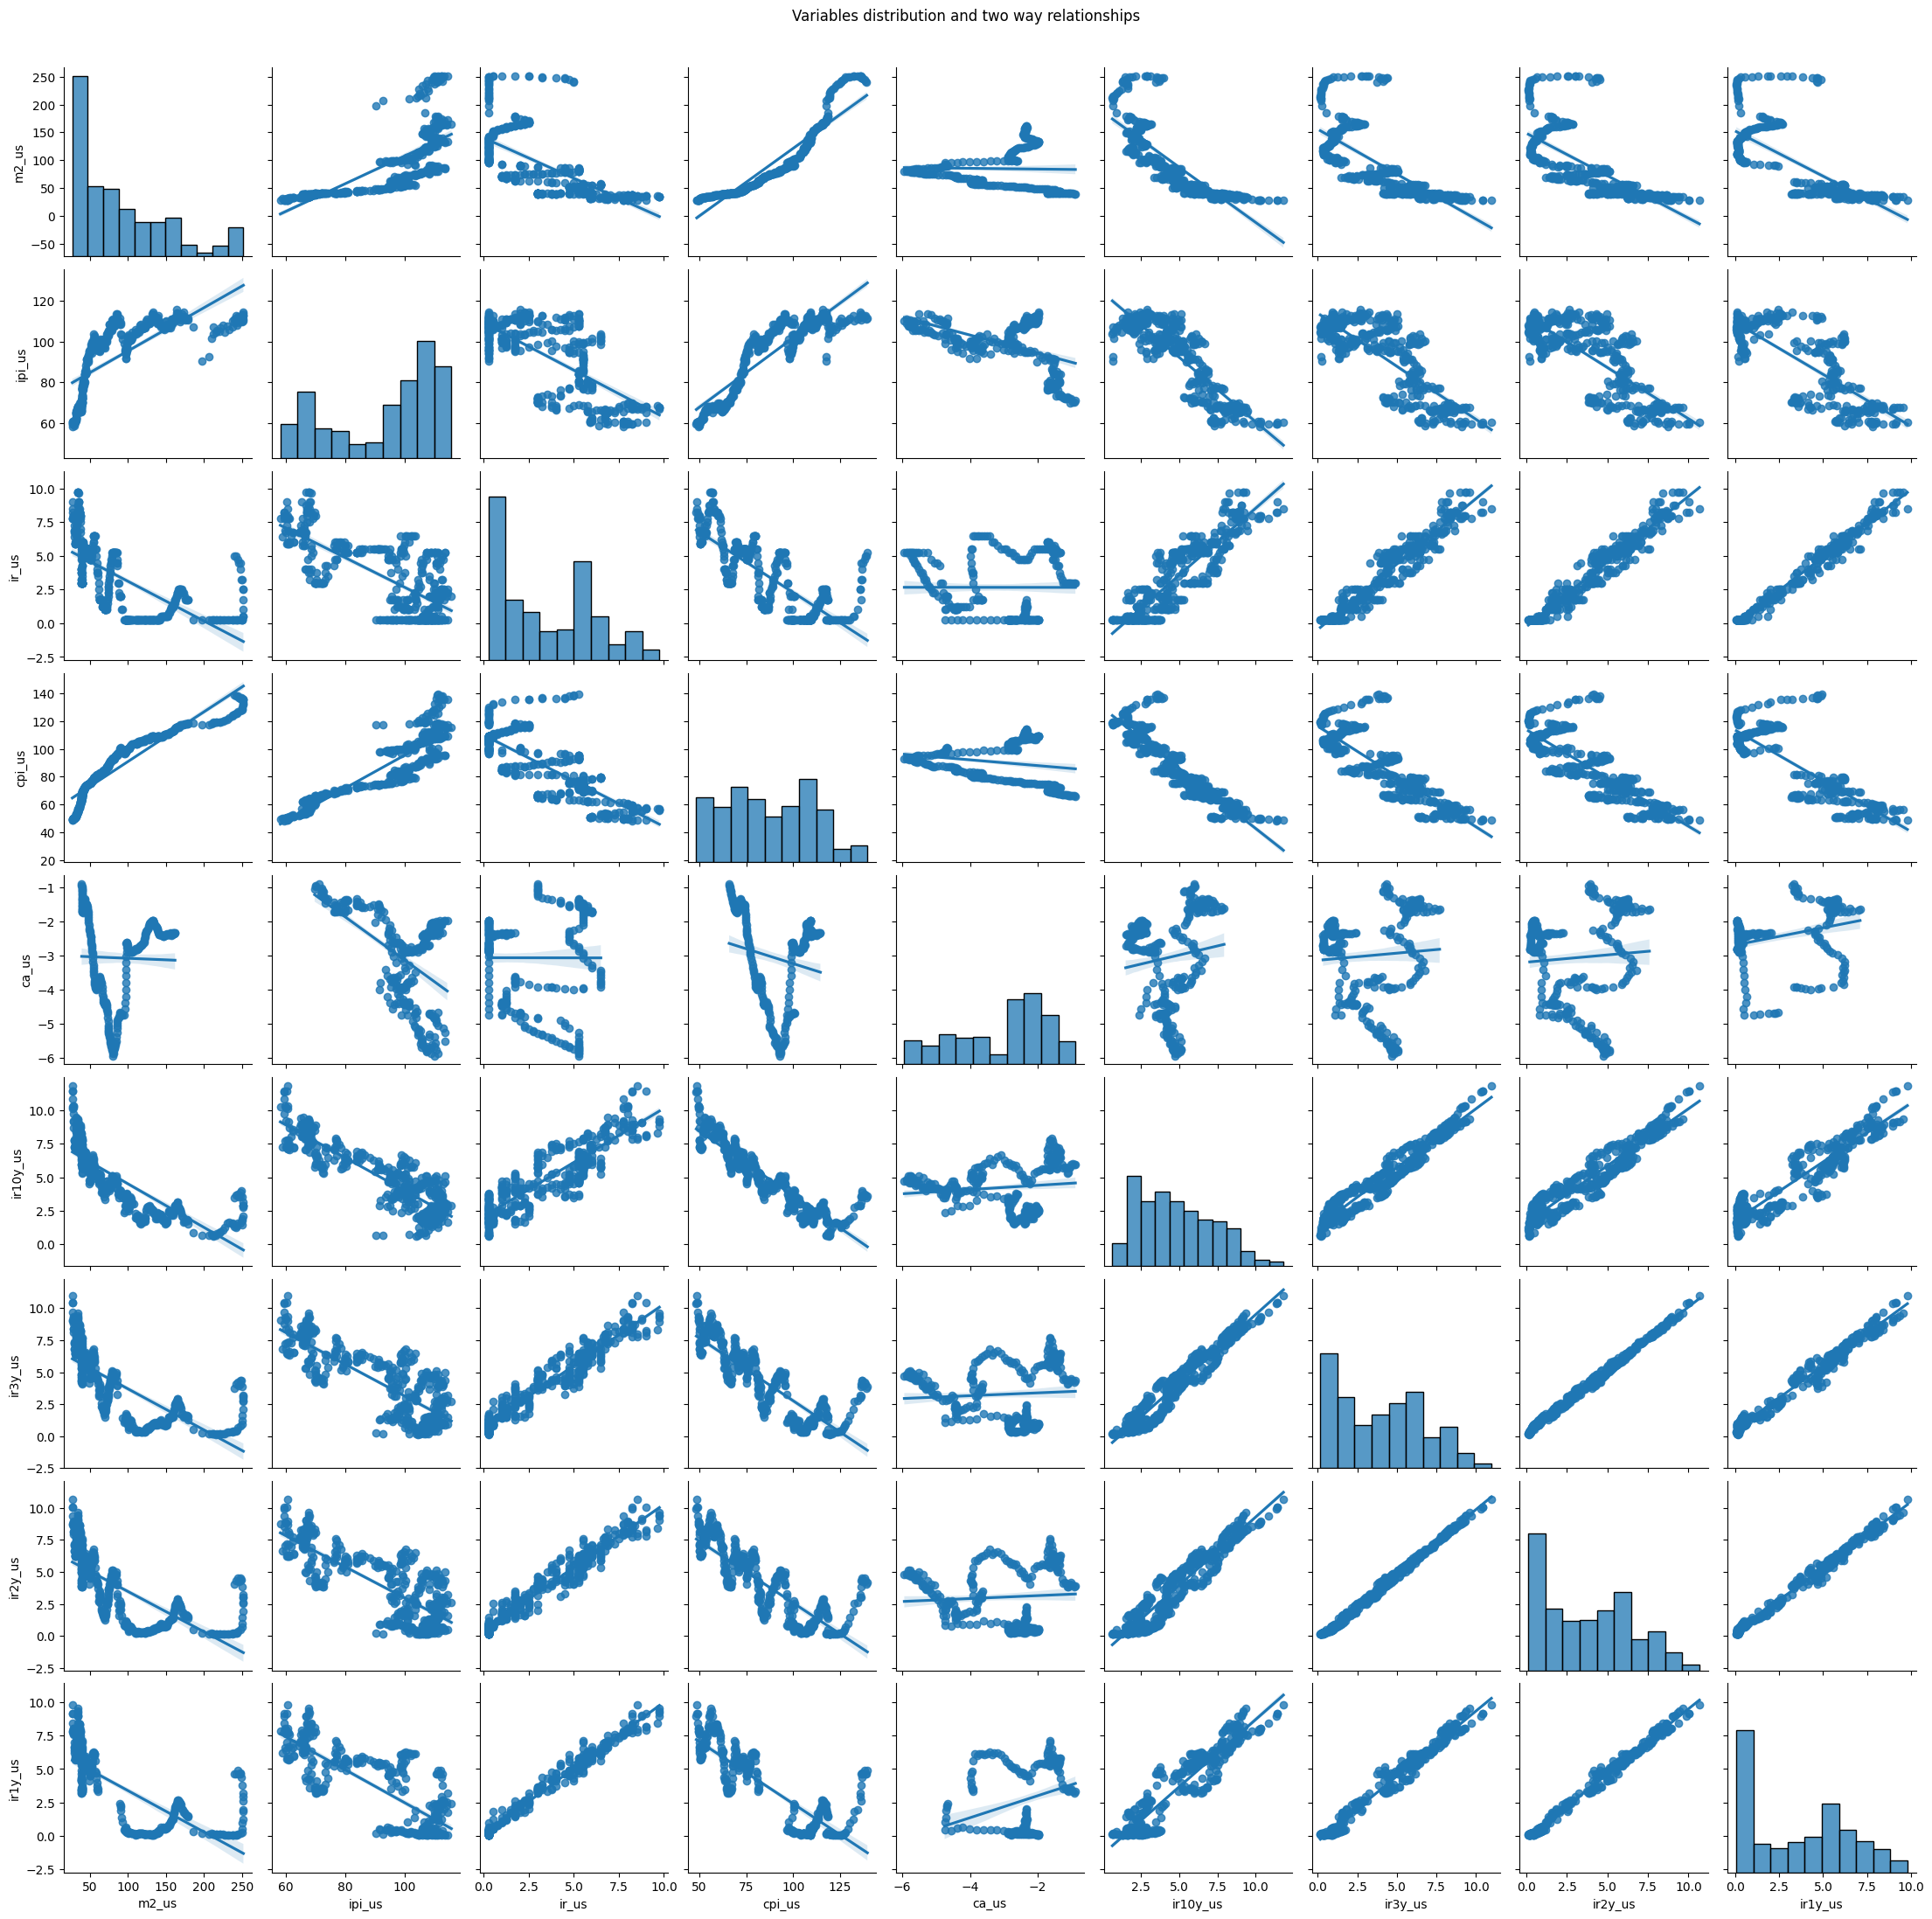

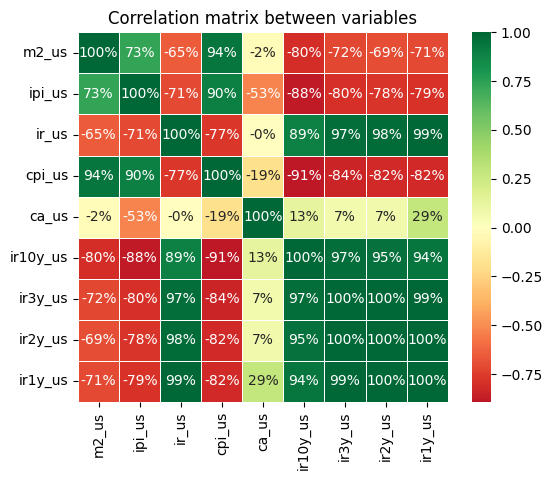

In [ ]:
#code to show exploratory data analysis

eda(data_m)

In [ ]:
#code to read original monthly data

path = '/content/drive/MyDrive/Internship/USDFAST.xlsx'
data_q = pd.read_excel(path, sheet_name = 'forecastm', index_col = 'Date').asfreq('q')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 160 entries, 1985-03-31 to 2024-12-31
Freq: Q-DEC
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Period    160 non-null    object 
 1   m2_us     153 non-null    float64
 2   ipi_us    153 non-null    float64
 3   ir_us     154 non-null    float64
 4   cpi_us    153 non-null    float64
 5   ca_us     101 non-null    float64
 6   ir10y_us  154 non-null    float64
 7   ir3y_us   150 non-null    float64
 8   ir2y_us   154 non-null    float64
 9   ir1y_us   127 non-null    float64
dtypes: float64(9), object(1)
memory usage: 13.8+ KB
None




,Period,m2_us,ipi_us,ir_us,cpi_us,ca_us,ir10y_us,ir3y_us,ir2y_us,ir1y_us
Date,,,,,,,,,,
1985-03-31,1Q1985,27.430678,60.386510,8.50,48.794917,NaN,11.822000,10.972839,10.675000,9.813556
1985-06-30,2Q1985,27.968580,60.600652,7.75,49.345236,NaN,10.142053,8.992042,8.663947,7.774632
1985-09-30,3Q1985,28.476341,60.572056,8.00,49.666255,NaN,10.336400,9.302610,8.952650,8.028950
1985-12-31,4Q1985,28.890201,59.838056,7.75,50.124854,NaN,9.233286,8.362457,8.123714,7.648524
1986-03-31,1Q1986,29.365502,60.164945,7.25,49.895554,NaN,7.754300,7.261245,7.186350,6.998650
1986-06-30,2Q1986,30.199018,60.777358,6.88,50.216573,NaN,7.773286,7.352976,7.148048,6.694524
1986-09-30,3Q1986,30.927040,61.059170,5.88,50.537592,NaN,7.422714,6.574271,6.322952,5.743143
1986-12-31,4Q1986,31.624922,60.556776,6.00,50.675172,NaN,7.093500,6.392273,6.246318,5.846455
1987-03-31,1Q1987,31.922854,62.551508,6.00,51.408930,NaN,7.228364,6.548832,6.401364,6.001909


,Period,m2_us,ipi_us,ir_us,cpi_us,ca_us,ir10y_us,ir3y_us,ir2y_us,ir1y_us
Date,,,,,,,,,,
2022-09-30,3Q2022,249.523878,112.811878,3.25,136.115805,NaN,3.506209,3.868232,3.846295,3.812205
2022-12-31,4Q2022,247.598328,110.724590,4.50,136.110761,NaN,3.618486,4.049736,4.296668,4.632141
2023-03-31,1Q2023,241.595621,112.684724,5.00,138.421640,NaN,3.662957,4.096065,4.310600,4.608700
2023-06-30,2Q2023,NaN,NaN,5.25,NaN,NaN,3.732007,4.210750,4.584207,5.179436
2023-09-30,3Q2023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-31,4Q2023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-31,1Q2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-30,2Q2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-09-30,3Q2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN




Data summary statistics


,m2_us,ipi_us,ir_us,cpi_us,ca_us,ir10y_us,ir3y_us,ir2y_us,ir1y_us
count,153.000000,153.000000,154.000000,153.000000,101.000000,154.000000,150.000000,154.000000,127.000000
mean,90.730734,93.907710,3.423831,87.442019,-3.052970,4.805531,4.014923,3.783525,3.597562
std,60.348120,17.701453,2.725841,23.193468,1.353285,2.439929,2.725419,2.747509,2.896232
min,27.430678,59.838056,0.250000,48.794917,-5.940000,0.675241,0.157114,0.129387,0.057750
25%,40.413358,76.861938,0.500000,68.514667,-4.130000,2.737206,1.464764,1.017100,0.370807
50%,71.296345,100.944222,3.000000,85.941423,-2.680000,4.535396,4.076175,3.860457,3.686826
75%,125.632552,108.534270,5.500000,107.084664,-2.060000,6.486958,6.147102,5.900795,5.799270
max,251.541010,114.143337,9.750000,138.421640,-0.890000,11.822000,10.972839,10.675000,9.813556


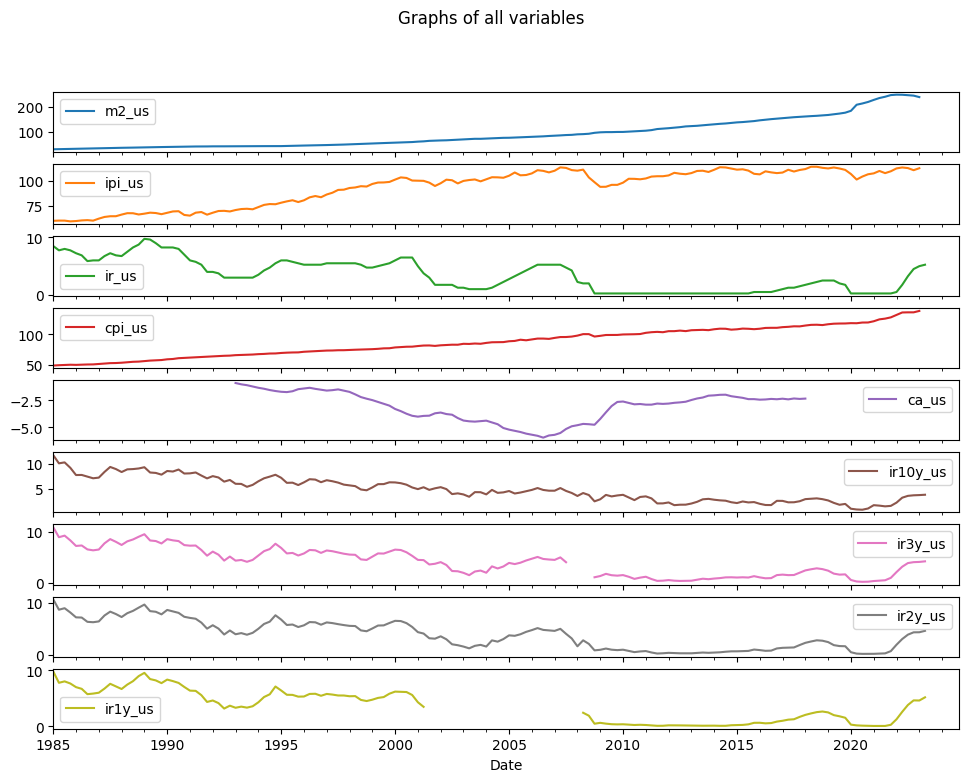

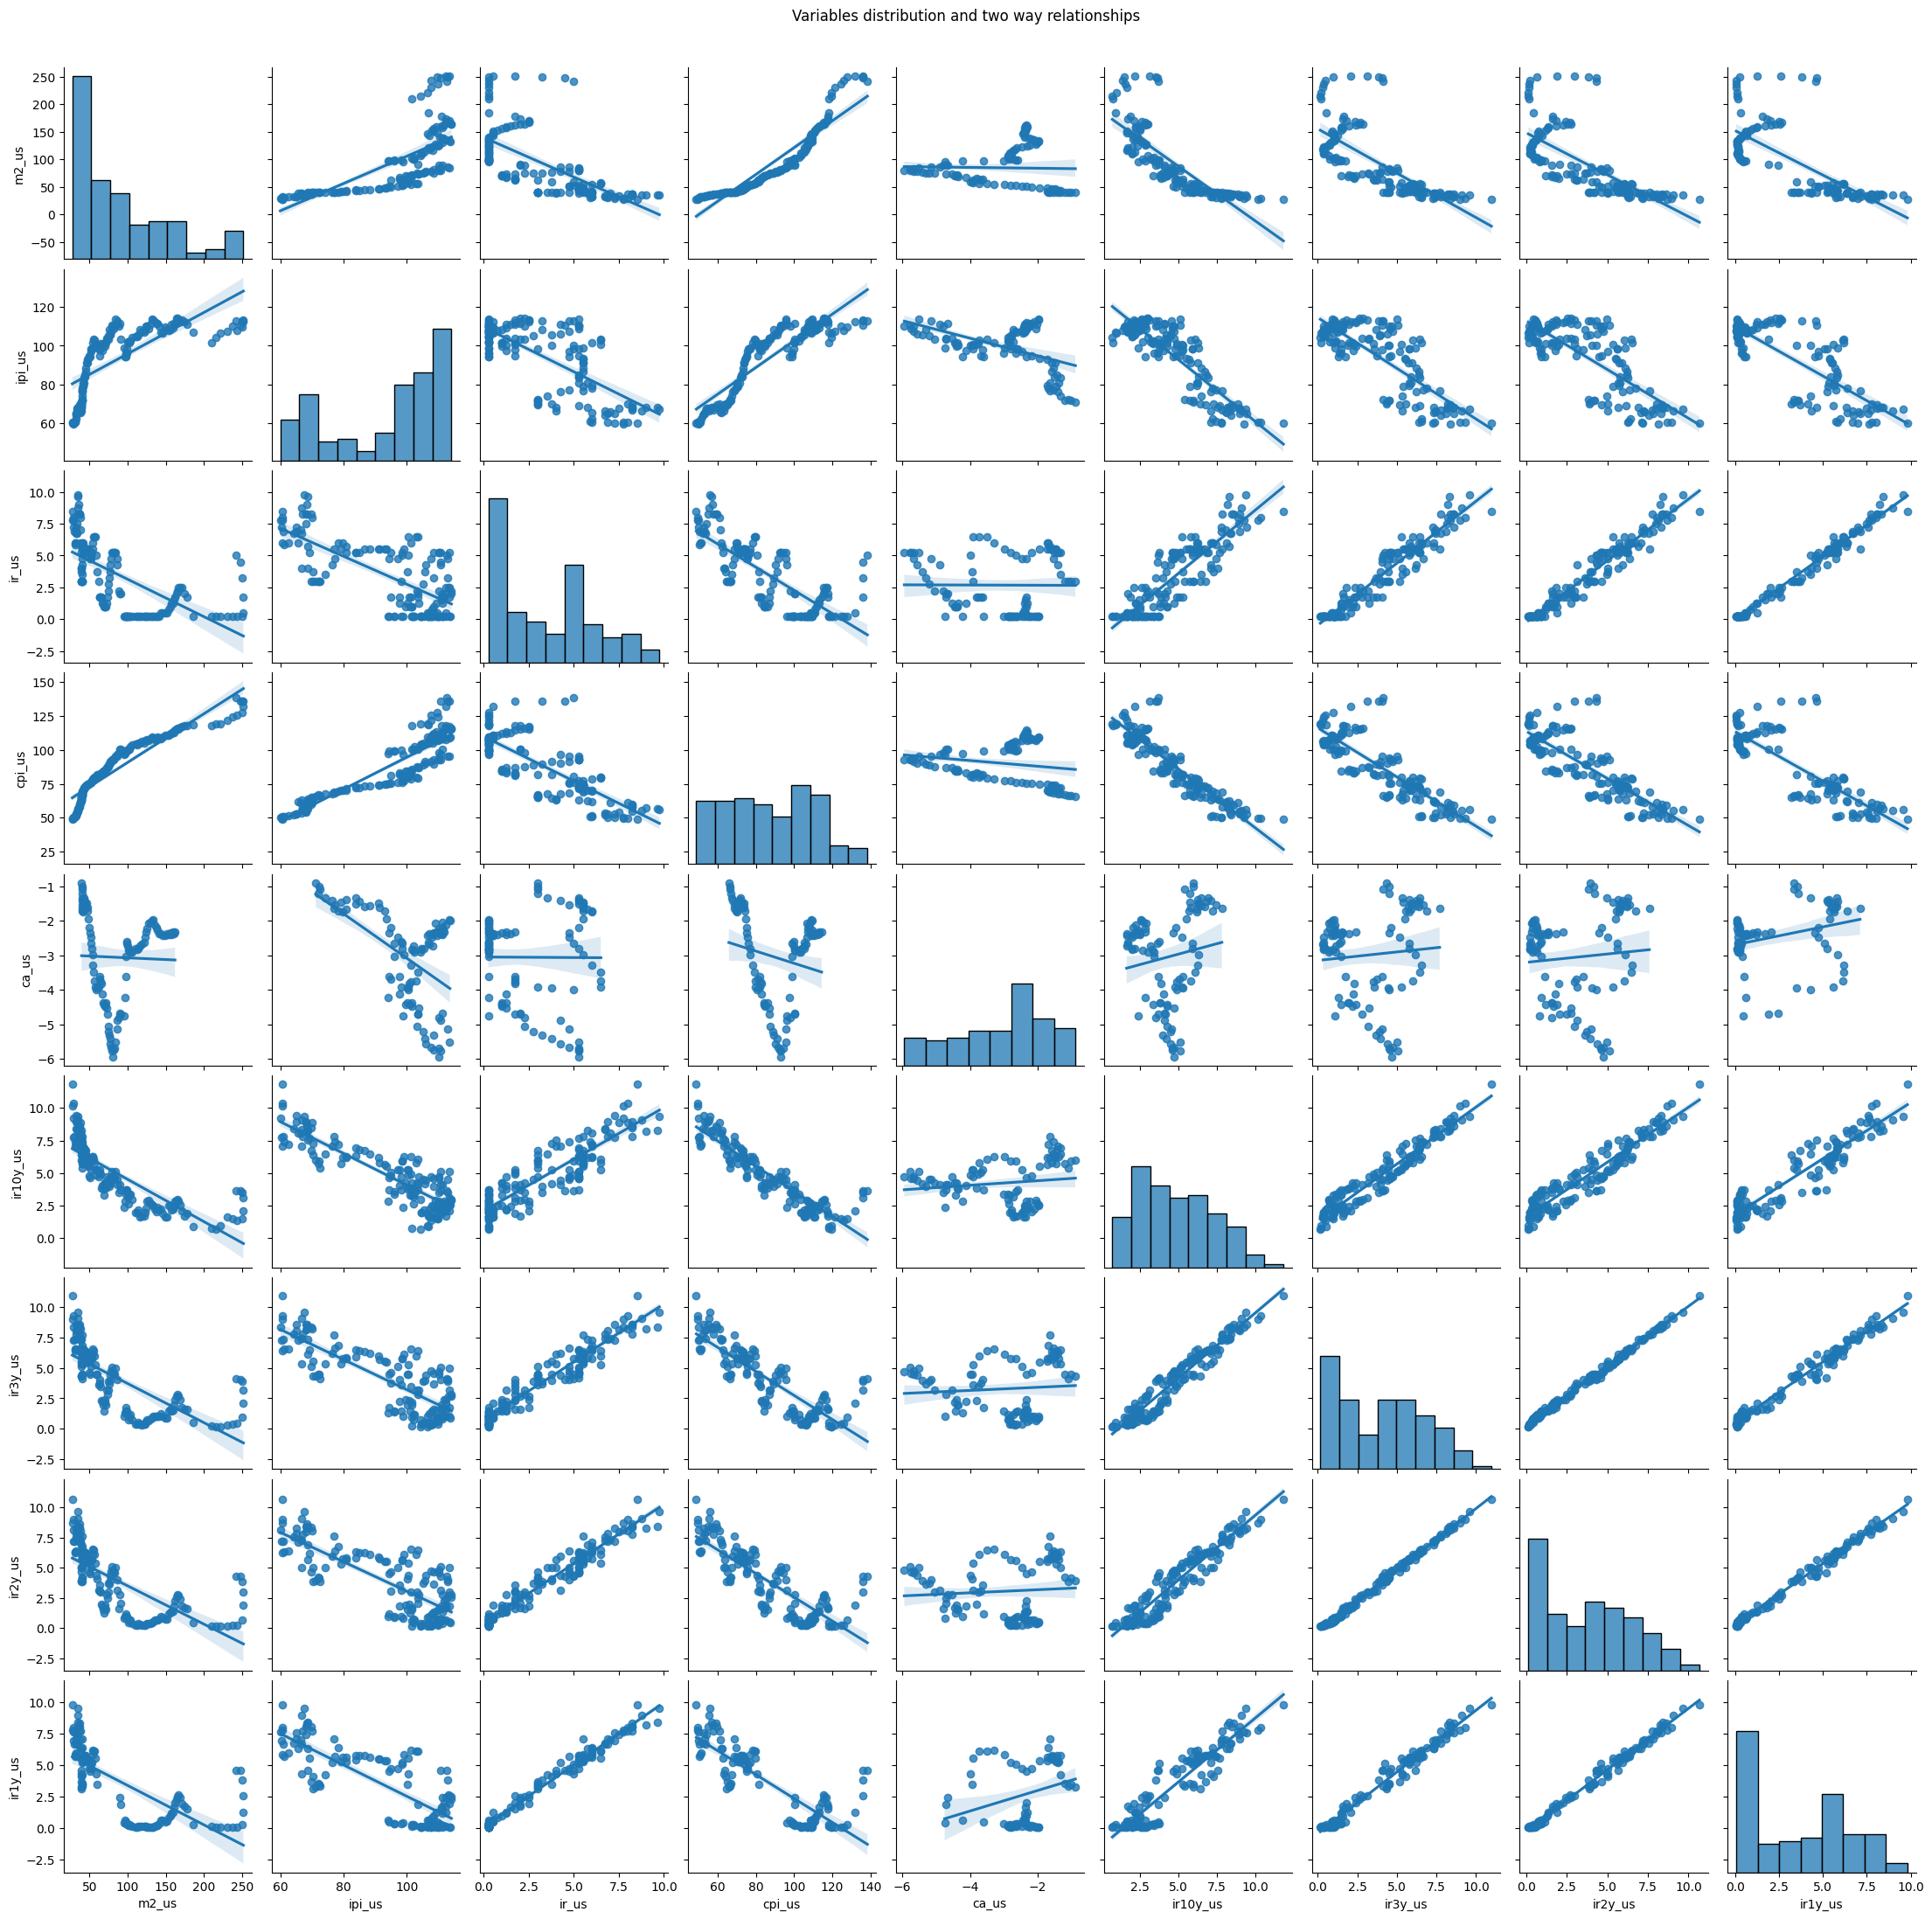

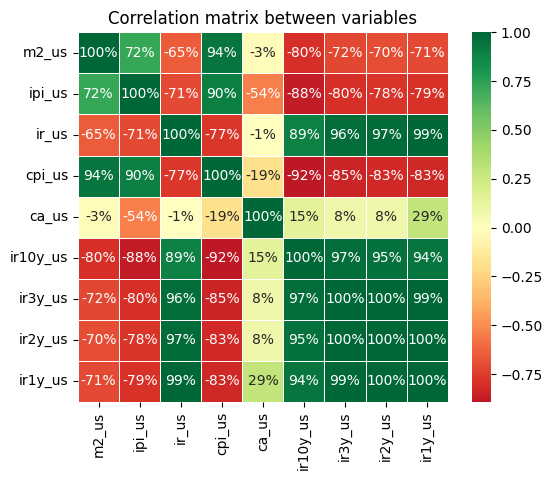

In [ ]:
#code to show exploratory data analysis

eda(data_q)

Variables selection for the model
Enter columns to be used in model seperated by space: ir10y_us


Sample selection and sample transformation
Please insert model sample start date in YYYY-MM-DD format: 1990-01
Please insert model sample end date in YYYY-MM-DD format: 2023-06
1 if need to log, 0 if no need to log: 1
1 if need to diff, 0 if no need to diff: 1
Index(['ir10y_us'], dtype='object')
Enter all columns' name to be log separated by space: ir10y_us
Index(['ir10y_us'], dtype='object')
Enter all columns' name to be diff separated by space: ir10y_us
1 if need second difference, 0 if do not need second difference: 0
Column: ir10y_us
Please enter the number of first difference i.e. 1 for difference to previous row, 12 for difference to previous 12 rows: 1


Model parameter setting and fitting
Please put the desired AR process number: 2
Please put the desired number of difference: 0
Please put the desired MA process number: 0
Please put the desired seasonal AR process number: 0
Please 

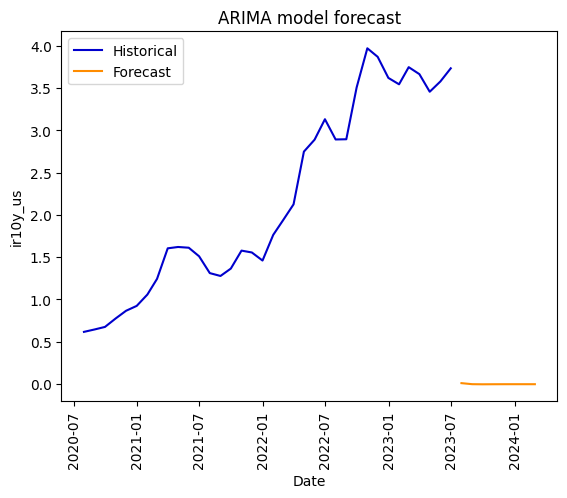




Enter the model name: arima
Aggregating forecast into quarterly numbers
1 for period avg, 0 for period end: 0
Forecast aggregated into quarterly end value


,arima,quarter,year
2023-09-30,-0.003009,3,2023
2023-12-31,-0.001884,4,2023


In [ ]:
#Running the first model, this example is running a monthly arima model with output aggregated into quarterly value for easier comparison later

arima_m = arima_forecast(data_m)

Variables selection for the model
Enter columns to be used in model seperated by space: ir10y_us


Sample selection and sample transformation
Please insert model sample start date in YYYY-MM-DD format: 1990-01
Please insert model sample end date in YYYY-MM-DD format: 2023-06
1 if need to log, 0 if no need to log: 1
1 if need to diff, 0 if no need to diff: 0
Index(['ir10y_us'], dtype='object')
Enter all columns' name to be log separated by space: ir10y_us


Model parameter setting and fitting
Please put the desired AR process number: 2
Please put the desired number of difference: 0
Please put the desired MA process number: 0
Please put the desired seasonal AR process number: 0
Please put the desired number of seasonal differnce: 0
Please put the desired seasonal MA process number: 0
Please put the frequency of the data: 4


                               SARIMAX Results                                
Dep. Variable:               ir10y_us   No. Observations:                  402
Model: 

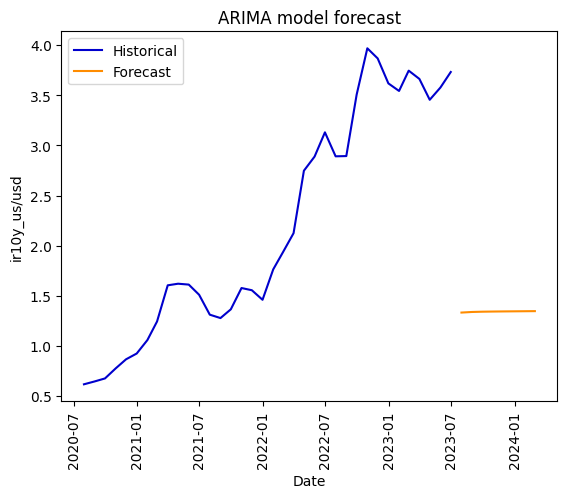




Enter the model name: arima
Aggregating forecast into quarterly numbers
1 for period avg, 0 for period end: 0
Forecast aggregated into quarterly end value


,arima,quarter,year
2023-09-30,1.340906,3,2023
2023-12-31,1.344670,4,2023


In [ ]:
# example 2 of arima, with no difference

arima_m = arima_forecast(data_m)

Variables selection for the model
Enter columns to be used in model seperated by space: ir10y_us


Sample selection and sample transformation
Please insert model sample start date in YYYY-MM-DD format: 1990-01
Please insert model sample end date in YYYY-MM-DD format: 2023-06
1 if need to log, 0 if no need to log: 0
1 if need to diff, 0 if no need to diff: 0


Model parameter setting and fitting
Please put the desired AR process number: 2
Please put the desired number of difference: 0
Please put the desired MA process number: 0
Please put the desired seasonal AR process number: 0
Please put the desired number of seasonal differnce: 0
Please put the desired seasonal MA process number: 0
Please put the frequency of the data: 4


                               SARIMAX Results                                
Dep. Variable:               ir10y_us   No. Observations:                  402
Model:                 ARIMA(2, 0, 0)   Log Likelihood                  57.439
Date:                Fri, 0

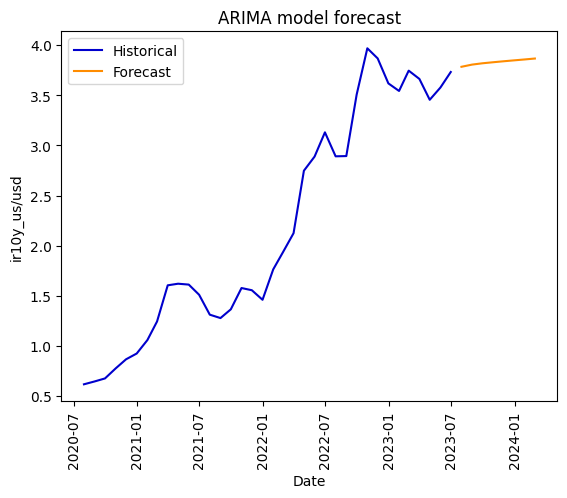




Enter the model name: arima
Aggregating forecast into quarterly numbers
1 for period avg, 0 for period end: 0
Forecast aggregated into quarterly end value


,arima,quarter,year
2023-09-30,3.818962,3,2023
2023-12-31,3.848231,4,2023


In [ ]:
# example 2 of arima, with no log and no difference

arima_m = arima_forecast(data_m)

Variables selection for the model
Enter columns to be used in model seperated by space: ir10y_us


Sample selection and sample transformation
Please insert model sample start date in YYYY-MM-DD format: 1990-01
Please insert model sample end date in YYYY-MM-DD format: 2023-06
1 if need to log, 0 if no need to log: 1
1 if need to diff, 0 if no need to diff: 1
Index(['ir10y_us'], dtype='object')
Enter all columns' name to be log separated by space: ir10y_us
Index(['ir10y_us'], dtype='object')
Enter all columns' name to be diff separated by space: ir10y_us
1 if need second difference, 0 if do not need second difference: 0
Column: ir10y_us
Please enter the number of first difference i.e. 1 for difference to previous row, 12 for difference to previous 12 rows: 1


Model parameter setting and fitting
Please put the desired AR process number: 2
Please put the desired number of difference: 0
Please put the desired MA process number: 0
Please put the desired seasonal AR process number: 0
Please 

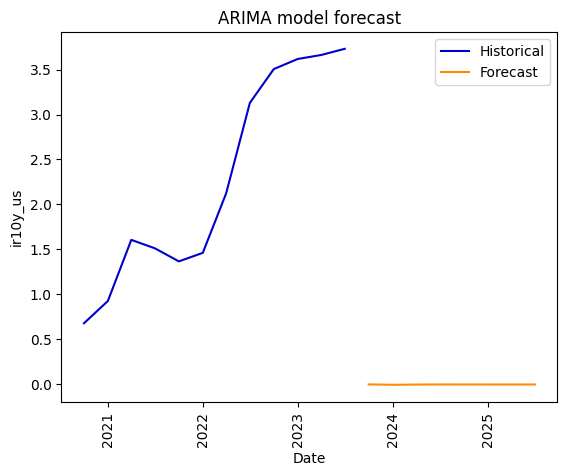




Enter the model name: arima
Aggregating forecast into quarterly numbers
1 for period avg, 0 for period end: 0
Forecast aggregated into quarterly end value


,arima,quarter,year
2023-09-30,-0.005034,3,2023
2023-12-31,-0.009775,4,2023
2024-03-31,-0.007080,1,2024
2024-06-30,-0.005957,2,2024
2024-09-30,-0.006170,3,2024
2024-12-31,-0.006367,4,2024
2025-03-31,-0.006368,1,2025
2025-06-30,-0.006339,2,2025


In [ ]:
#Running the first model, this example is running a monthly arima model with output aggregated into quarterly value for easier comparison later

arima_q = arima_forecast(data_q)

Variables selection for the model
Enter columns to be used in model seperated by space: ir10y_us cpi_us m2_us ipi_us
Please put your dependent variable name: ir10y_us

Sample selection and sample transformation
Please insert model sample start date in YYYY-MM-DD format: 1990-01
Please insert model sample end date in YYYY-MM-DD format: 2023-06
1 if need to log, 0 if no need to log: 1
1 if need to diff, 0 if no need to diff: 1
Index(['ir10y_us', 'cpi_us', 'm2_us', 'ipi_us'], dtype='object')
Enter all columns' name to be log separated by space: ir10y_us cpi_us m2_us ipi_us
Index(['ir10y_us', 'cpi_us', 'm2_us', 'ipi_us'], dtype='object')
Enter all columns' name to be diff separated by space: ir10y_us cpi_us m2_us ipi_us
1 if need second difference, 0 if do not need second difference: 0
Column: ir10y_us
Please enter the number of first difference i.e. 1 for difference to previous row, 12 for difference to previous 12 rows: 1
Column: cpi_us
Please enter the number of first difference i.e. 1 

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)




                            OLS Regression Results                            
Dep. Variable:       np.log(ir10y_us)   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     6.096
Date:                Thu, 05 Oct 2023   Prob (F-statistic):            0.00389
Time:                        08:39:21   Log-Likelihood:                -95.740
No. Observations:                  63   AIC:                             197.5
Df Residuals:                      60   BIC:                             203.9
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.3081      0.145    -22.813      0

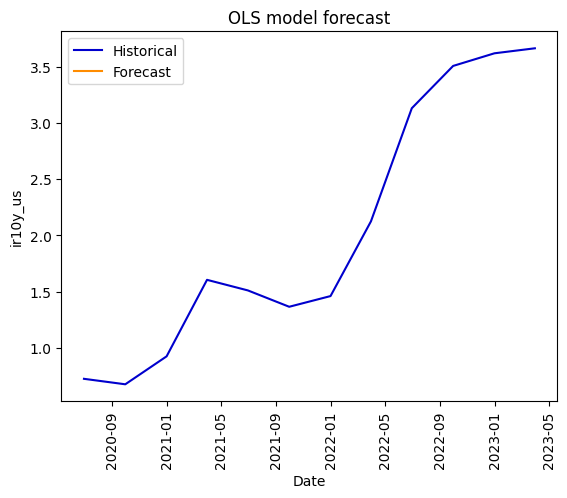




Enter the model name: ols
Aggregating forecast into quarterly numbers
1 for period avg, 0 for period end: 0
Forecast aggregated into quarterly end value


,ols,quarter,year
Date,,,


In [ ]:
# forecast using OLS

ols_1 = ols_forecast(data_q)

Variables selection for the model
Enter columns to be used in model seperated by space: ir10y_us cpi_us m2_us ipi_us
Please put your dependent variable name: ir10y_us

Sample selection and sample transformation
Please insert model sample start date in YYYY-MM-DD format: 1990-01
Please insert model sample end date in YYYY-MM-DD format: 2023-06
1 if need to log, 0 if no need to log: 1
1 if need to diff, 0 if no need to diff: 0
Index(['ir10y_us', 'cpi_us', 'm2_us', 'ipi_us'], dtype='object')
Enter all columns' name to be log separated by space: ir10y_us cpi_us m2_us ipi_us

Model parameter setting and fitting
Please put the formula of the ols, for example log brent linear model with balance and recession indicator as exogenous variables will have a formula such as 'np.log(brent) ~ balance + recession': np.log(ir10y_us)~m2_us + cpi_us


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)




                            OLS Regression Results                            
Dep. Variable:       np.log(ir10y_us)   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     62.79
Date:                Fri, 06 Oct 2023   Prob (F-statistic):           1.21e-19
Time:                        01:28:33   Log-Likelihood:                 5.0477
No. Observations:                 129   AIC:                            -4.095
Df Residuals:                     126   BIC:                             4.484
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.5300      2.787     -0.190      0

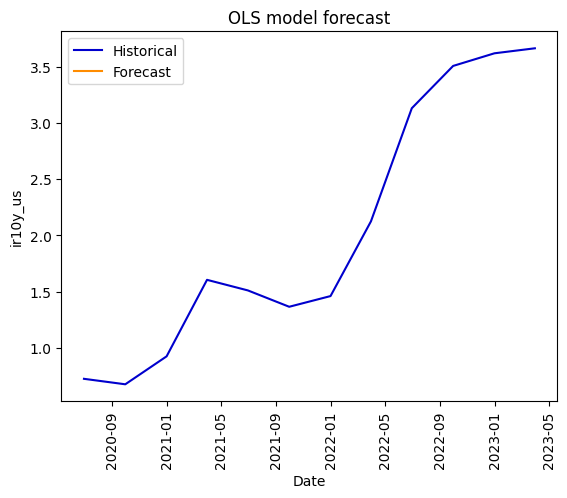




Enter the model name: ols
Aggregating forecast into quarterly numbers
1 for period avg, 0 for period end: 0
Forecast aggregated into quarterly end value


,ols,quarter,year
Date,,,


In [ ]:
# forecast using OLS with no difference

ols_1 = ols_forecast(data_q)

Variables selection for the model
Enter columns to be used in model seperated by space: ir10y_us cpi_us m2_us ipi_us
Please enter the name of your main endogenous variables: ir10y_us

Sample selection and sample transformation
Please insert model sample start date in YYYY-MM-DD format: 1990-01
Please insert model sample end date in YYYY-MM-DD format: 2023-06
1 if need to log, 0 if no need to log: 1
1 if need to diff, 0 if no need to diff: 1
Index(['ir10y_us', 'cpi_us', 'm2_us', 'ipi_us'], dtype='object')
Enter all columns' name to be log separated by space: ir10y_us
Index(['ir10y_us', 'cpi_us', 'm2_us', 'ipi_us'], dtype='object')
Enter all columns' name to be diff separated by space: ir10y_us
1 if need second difference, 0 if do not need second difference: 0
Column: ir10y_us
Please enter the number of first difference i.e. 1 for difference to previous row, 12 for difference to previous 12 rows: 1

Model parameter setting and fitting
<statsmodels.tsa.vector_ar.var_model.LagOrderResults 

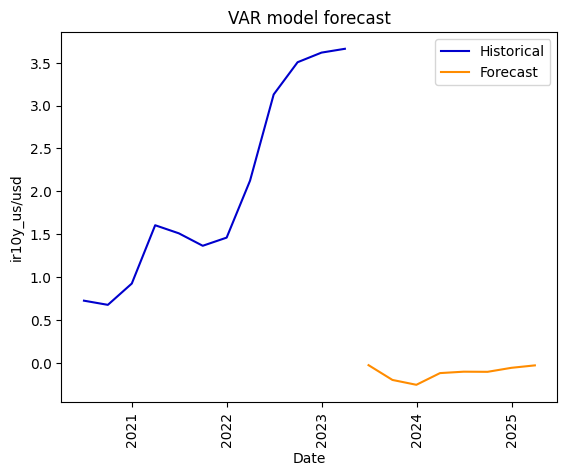




Enter the model name: var
Aggregating forecast into quarterly numbers
1 for period avg, 0 for period end: 0
Forecast aggregated into quarterly end value


,var
2023-06-30,-0.028415
2023-09-30,-0.200902
2023-12-31,-0.257523
2024-03-31,-0.121014
2024-06-30,-0.104504
2024-09-30,-0.106158
2024-12-31,-0.059261
2025-03-31,-0.030939


In [ ]:
# forecast VAR model using quarterly

var_q = var_forecast(data_q)

Variables selection for the model
Enter columns to be used in model seperated by space: ir10y_us cpi_us m2_us ipi_us
Please enter the name of your main endogenous variables: ir10y_us

Sample selection and sample transformation
Please insert model sample start date in YYYY-MM-DD format: 1990-01
Please insert model sample end date in YYYY-MM-DD format: 2023-06
1 if need to log, 0 if no need to log: 1
1 if need to diff, 0 if no need to diff: 1
Index(['ir10y_us', 'cpi_us', 'm2_us', 'ipi_us'], dtype='object')
Enter all columns' name to be log separated by space: ir10y_us cpi_us m2_us ipi_us
Index(['ir10y_us', 'cpi_us', 'm2_us', 'ipi_us'], dtype='object')
Enter all columns' name to be diff separated by space: ir10y_us cpi_us m2_us ipi_us
1 if need second difference, 0 if do not need second difference: 0
Column: ir10y_us
Please enter the number of first difference i.e. 1 for difference to previous row, 12 for difference to previous 12 rows: 1
Column: cpi_us
Please enter the number of first di

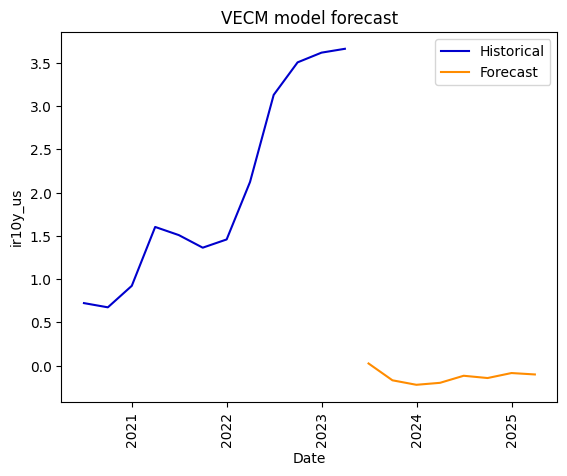




Enter the model name: vecm
Aggregating forecast into quarterly numbers
1 for period avg, 0 for period end: 0
Forecast aggregated into quarterly end value


,vecm
2023-06-30,0.026434
2023-09-30,-0.168098
2023-12-31,-0.219994
2024-03-31,-0.197202
2024-06-30,-0.115573
2024-09-30,-0.141850
2024-12-31,-0.084127
2025-03-31,-0.100505


In [ ]:
# forecast VECM model using quarterly

vecm_q = vecm_forecast(data_q)